In [2]:
# Necesarry imports
import pandas as pd
from sklearn import svm, linear_model
from sklearn.utils import shuffle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
# settings to display all columns
pd.set_option("display.max_columns", None)

In [3]:
C = ["XS", "S", "M", "L"]

In [4]:
final_df = pd.read_csv("../data/final_dataset.csv")

/Users/luca/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,21,22,114) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
car_df = final_df[final_df["vehicleType"] == "car"]

# Add the vehicle class
classes = { 'BMW 1er': "M",
 'BMW 2er Active Tourer': "M", 'BMW 2er Cabrio': "L", 'BMW I3': "M",
       'BMW X1': "L", 'BMW X2': "L", 'MINI 3-tuerer': "S", 'MINI 5-tuerer': "S",
       'MINI Cabrio': "S", 'MINI Clubman': "S", 'MINI Countryman': "S",
       'Mercedes-Benz A-Klasse': "M", 'Mercedes-Benz B-Klasse': "M",
       'Mercedes-Benz GLA': "M", 'bmw 1er': "M", 'bmw 2er active tourer': "M",
       'bmw 2er cabrio': "L", 'bmw i3': "M", 'bmw x1': "L", 'bmw x2': "L", 'mini 3-tuerer': "S",
       'mini 5-tuerer': "S", 'mini cabrio': "S", 'mini clubman': "S", 'mini countryman': "S",
       'smart fortwo 3rd generation': "XS"}

car_df["class"] = car_df["model"].apply(lambda model: classes[model])

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_21570/631624269.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df["class"] = car_df["model"].apply(lambda model: classes[model])


In [155]:
age_src_columns = ["Unter 18", "18 - 29","30 - 49","50 - 64","65 und älter"]
hh_src_columns = ["Einpersonenhaushalte (Singlehaushalte)", "Paare ohne Kind(er)", "Alleinerziehende Elternteile", "Paare mit Kind(ern)", "Mehrpersonenhaushalte ohne Kernfamilie"]

tmp_df = car_df[[*age_src_columns, *hh_src_columns, "distance", "class", "Bezirk"]]

# Calculate the distribution classes
def calculate_dist(columns: list[str], prefix: str):
  sum = tmp_df[columns].sum(axis=1)
  for (i, c) in enumerate(columns):
    tmp_df[f"{prefix}_{i + 1}"] = (tmp_df[c] / sum)

calculate_dist(age_src_columns, "age")
calculate_dist(hh_src_columns, "hh")

# Now drop the unused classes
learning_df = tmp_df.drop([*age_src_columns, *hh_src_columns, "Bezirk"], axis=1)

# Also drop malformed entries
learning_df.dropna(inplace=True)

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_21570/590529843.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[f"{prefix}_{i + 1}"] = (tmp_df[c] / sum)


In [67]:
# Also create the bezirks data for the stations in the simulation stage
bezirk_df = tmp_df.drop([*age_src_columns, *hh_src_columns, "class", "distance"], axis=1)
print(bezirk_df.groupby("Bezirk").count().sort_values("age_1"))
bezirk_df = bezirk_df.groupby("Bezirk").mean()

# Aaand normalize columns
def normalize_columns(columns):
  sum = bezirk_df[columns].sum(axis=1)
  for c in columns:
    bezirk_df[c] = bezirk_df[c] / sum

normalize_columns([f"age_{i}" for i in range(1, 6)])
normalize_columns([f"hh_{i}" for i in range(1, 6)])


                             age_1   age_2   age_3   age_4   age_5    hh_1  \
Bezirk                                                                       
Marzahn-Hellersdorf           1411    1411    1411    1411    1411    1411   
Spandau                      30524   30524   30524   30524   30524   30524   
Treptow-Köpenick             34915   34915   34915   34915   34915   28163   
Reinickendorf                55422   55422   55422   55422   55422   53897   
Lichtenberg                  65295   65295   65295   65295   65295   64832   
Steglitz-Zehlendorf          91244   91244   91244   91244   91244   89379   
Neukölln                    117170  117170  117170  117170  117170  115628   
Tempelhof-Schöneberg        198518  198518  198518  198518  198518  197847   
Pankow                      216460  216460  216460  216460  216460  216203   
Charlottenburg-Wilmersdorf  327215  327215  327215  327215  327215  322800   
Friedrichshain-Kreuzberg    340491  340491  340491  340491  3404

In [64]:
header = ["Under 18 Years", "18-29 Years", "30-49 Years", "50-64 Years", "Over 65 Years", "Single Household", "Pairs", "Single Parents", "Parents with children", "Multiperson household"]
# bezirk_df[[f"hh_{i}" for i in range(1, 6)]].sum(axis=1)
bezirk_df.to_latex("../paper/Appendices/district-table.tex", header=header, longtable=True, label="table:Districts", float_format="%.2f")

In [65]:
bezirk_df

,age_1,age_2,age_3,age_4,age_5,hh_1,hh_2,hh_3,hh_4,hh_5
Bezirk,,,,,,,,,,
Charlottenburg-Wilmersdorf,0.123084,0.140940,0.303421,0.230224,0.202331,0.555159,0.202011,0.074154,0.135922,0.032754
Friedrichshain-Kreuzberg,0.139032,0.227621,0.401664,0.143107,0.088576,0.535791,0.148643,0.074135,0.133834,0.107596
Lichtenberg,0.134709,0.228394,0.316003,0.155271,0.165623,0.490168,0.240385,0.091568,0.137804,0.040073
Marzahn-Hellersdorf,0.053946,0.073412,0.338088,0.265322,0.269231,0.254053,0.637242,0.016507,0.091414,0.000783
Mitte,0.136112,0.202399,0.362449,0.174926,0.124114,0.563059,0.169525,0.070242,0.132560,0.064615
Neukölln,0.151298,0.230332,0.350282,0.157846,0.110242,0.543705,0.156648,0.077594,0.129284,0.092768
Pankow,0.153471,0.176441,0.456331,0.113997,0.099759,0.546312,0.174585,0.084311,0.138146,0.056646
Reinickendorf,0.150823,0.154017,0.291188,0.188156,0.215815,0.492691,0.205778,0.132443,0.120349,0.048739
Spandau,0.122691,0.166697,0.284365,0.236353,0.189894,0.562037,0.206568,0.084230,0.126838,0.020327


In [8]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983246 entries, 303541 to 2636051
Columns: 139 entries, id to class
dtypes: bool(3), float64(94), int64(16), object(26)
memory usage: 2.0+ GB


In [70]:
simulation_districts = ["Pankow", "Reinickendorf", "Friedrichshain-Kreuzberg", "Charlottenburg-Wilmersdorf"]

relevant_data = car_df.loc[car_df["Bezirk"].isin(simulation_districts), "datetime_start"]

r = pd.to_datetime(relevant_data,errors='coerce', utc=True)
hour_df = pd.DataFrame(data={"day": r.dt.date, "hour": r.dt.hour, "id": relevant_data.index})

In [71]:
hour_df

,day,hour,id
303542,2020-01-17,11,303542
303545,2020-01-18,3,303545
303550,2020-01-19,17,303550
303552,2020-01-20,20,303552
303553,2020-01-20,20,303553
...,...,...,...
2636033,2019-10-29,14,2636033
2636041,2019-11-04,16,2636041
2636042,2020-01-04,12,2636042
2636049,2019-11-03,14,2636049


Text(0, 0.5, 'Average number of rentals')

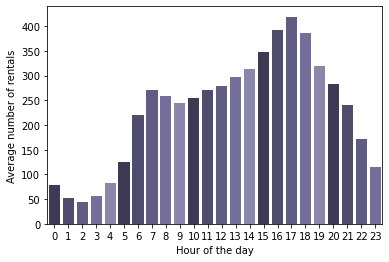

In [72]:
hd = hour_df.groupby(["day", "hour"]).count()
# palette = sns.light_palette("#786fa6")
# sns.barplot(x=hd.index, y=hd.values, palette=palette
daily_demand = hd.groupby("hour").mean().round()

palette = sns.color_palette(["#3B3659", "#4C4672", "#5C558B", "#6F67A2", "#8781B1"])
sns.barplot(data=daily_demand, x=daily_demand.index, y="id", palette=palette)
plt.xlabel("Hour of the day")
plt.ylabel("Average number of rentals")

In [169]:
start = pd.to_datetime(car_df["datetime_start"], utc=True)
end = pd.to_datetime(car_df["datetime_end"], utc=True)

In [192]:
diff = car_df["distance"] / (end - start).dt.seconds
diff = diff * 60

In [193]:
diff.replace([np.inf, -np.inf], np.nan).dropna().mean()

126.39280907696697

In [191]:
car_df["distance"].mean()

4451.397745641143

In [117]:
# Figure out the availability of classes
unique_cars = car_df.groupby("class")["id"].nunique()
num_of_dp = learning_df.groupby("class")["class"].count()
min_class = num_of_dp.idxmin()


def truncate_shuffle(c):
  num = num_of_dp[c]
  unique = unique_cars[c]

  scale = unique_cars[c] / unique_cars[min_class]
  truncated_num = round(scale * num_of_dp[min_class])

  a = learning_df.loc[learning_df["class"] == c, :]
  shuffle(a)
  a = a[:80000] # truncated_num

  print(c, num, unique, scale, truncated_num, a.shape)
  return a

learning_df = pd.concat([truncate_shuffle(c) for c in C])

XS 1082807 1007 3.4844290657439445 261587 (80000, 12)
S 423767 1492 5.162629757785467 387574 (80000, 12)
M 369569 1158 4.006920415224913 300812 (80000, 12)
L 75073 289 1.0 75073 (75073, 12)


In [156]:
learning_df.groupby("class").count()

,distance,age_1,age_2,age_3,age_4,age_5,hh_1,hh_2,hh_3,hh_4,hh_5
class,,,,,,,,,,,
L,75073,75073,75073,75073,75073,75073,75073,75073,75073,75073,75073
M,369569,369569,369569,369569,369569,369569,369569,369569,369569,369569,369569
S,423767,423767,423767,423767,423767,423767,423767,423767,423767,423767,423767
XS,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807


In [222]:
# Training a classifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

X = learning_df.loc[:, learning_df.columns != "class"]
Y = learning_df.loc[:, learning_df.columns == "class"]["class"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(X_train.values, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('complementnb', ComplementNB())])

In [145]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train.values, y_train)

/Users/luca/mambaforge/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [214]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

nn_clf = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=1200))
nn_clf.fit(X_train, y_train)

/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=1200, random_state=1))])

In [207]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgd_clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, class_weight="balanced", loss="log"))

sgd_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', loss='log'))])

In [217]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
 
# Test the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

imps = permutation_importance(clf, X_test, y_test)
print(imps.importances_mean)

              precision    recall  f1-score   support

           L       0.04      0.03      0.03     24819
           M       0.20      0.03      0.05    122052
           S       0.22      0.50      0.31    140145
          XS       0.57      0.48      0.52    356886

    accuracy                           0.38    643902
   macro avg       0.26      0.26      0.23    643902
weighted avg       0.40      0.38      0.37    643902

[-1.31448574e-03  4.19318468e-04  1.07842498e-03  5.25235207e-03
  4.73581384e-03  2.53268355e-03  1.01257645e-04 -1.05606133e-05
  1.54216014e-03 -3.10326727e-03  5.00076099e-05]


In [208]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
# Test the classifier
y_pred = sgd_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           L       0.04      0.00      0.01     24819
           M       0.23      0.00      0.00    122052
           S       0.25      0.01      0.01    140145
          XS       0.55      0.99      0.71    356886

    accuracy                           0.55    643902
   macro avg       0.27      0.25      0.18    643902
weighted avg       0.41      0.55      0.40    643902



In [271]:
from simulation import Simulation

p = 1 / daily_demand["id"]
station_data = bezirk_df.loc[bezirk_df.index.isin(simulation_districts), :]

s = Simulation(station_data=station_data, p=p, alpha=0.005, capacity=20, pred=clf.predict_proba)



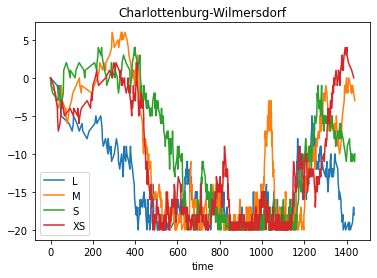

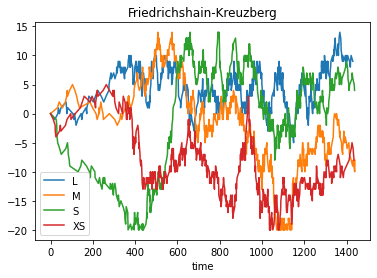

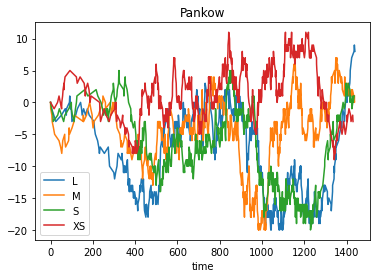

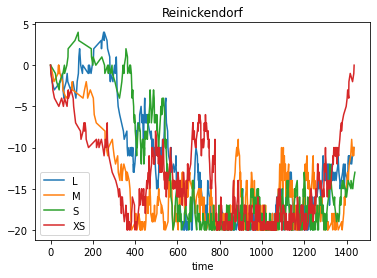

In [272]:
for station in s.stations:
  plt.title(station.name)
  for (c, df) in station.history_df.items():
    sns.lineplot(x=df.index, y=df["amount"].values)
  plt.legend(labels=station.history_df.keys())
  plt.show()

In [213]:
sgd_clf.predict_proba([[5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]])
  

/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.21679355, 0.23968739, 0.2636408 , 0.27987826]])

In [101]:
X

,distance,age_1,age_2,age_3,age_4,age_5,hh_1,hh_2,hh_3,hh_4,hh_5
303541,3637.190728,0.078231,0.387755,0.295918,0.153061,0.085034,0.712264,0.132075,0.042453,0.056604,0.056604
303542,6230.522471,0.134328,0.089552,0.313433,0.253731,0.208955,0.680851,0.127660,0.063830,0.063830,0.063830
303543,14100.029888,0.134420,0.230143,0.362525,0.203666,0.069246,0.655844,0.149351,0.077922,0.061688,0.055195
303544,6076.262732,0.204301,0.204301,0.365591,0.150538,0.075269,0.348837,0.395349,0.000000,0.255814,0.000000
303545,11464.318079,0.117284,0.172840,0.567901,0.104938,0.037037,0.587629,0.134021,0.051546,0.123711,0.103093
...,...,...,...,...,...,...,...,...,...,...,...
2636047,2653.660695,0.197368,0.157895,0.381579,0.203947,0.059211,0.289855,0.246377,0.115942,0.217391,0.130435
2636048,2693.432683,0.207207,0.162162,0.342342,0.171171,0.117117,0.354167,0.187500,0.145833,0.250000,0.062500
2636049,2853.187958,0.197368,0.157895,0.381579,0.203947,0.059211,0.289855,0.246377,0.115942,0.217391,0.130435
2636050,3876.988333,0.197368,0.157895,0.381579,0.203947,0.059211,0.289855,0.246377,0.115942,0.217391,0.130435


In [120]:
def age_class(i, name):
  car_df[f"age_{i}"] = car_df[name] / car_df["Einheiten insgesamt"]

age_class(1, "Unter 18")
age_class(2, "18 - 29")
age_class(3, "30 - 49")
age_class(4, "50 - 64")
age_class(5, "65 und älter")


/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_8819/1650322770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df[f"age_{i}"] = car_df[name] / car_df["Einheiten insgesamt"]


In [40]:
income_curr = ["Erwerbstätige / Monatliches Nettoeinkommen unter 900", "Erwerbstätige / Monatliches Nettoeinkommen 900 – 1500", "Erwerbstätige / Monatliches Nettoeinkommen 1500 und mehr"]

car_df["income_total"] = car_df[income_curr].sum(axis=1)

def income_class(i, name):
  car_df[f"income_{i}"] = car_df[name] / car_df["income_total"]

for (i, name) in enumerate(income_curr):
  income_class(i + 1, name)

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_84983/1647027980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df["income_total"] = car_df[income_curr].sum(axis=1)
/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_84983/1647027980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df[f"income_{i}"] = car_df[name] / car_df["income_total"]


In [41]:
car_df.head()

,id,provider,city,vehicleType,model,datetime_start,date_start,time_start,datetime_end,date_end,time_end,longitude_start,latitude_start,longitude_end,latitude_end,fuel_start,fuel_end,distance,duration,price_driving_start,price_driving_end,price_promo_start,price_promo_end,idle_duration,geometry,missing_file_number,h3_9,tier,emio,callabike,bmw 2er active tourer,bmw 2er cabrio,bmw x2,mercedes-benz gla,bmw x1,mercedes-benz a-klasse,mini 3-tuerer,mini 5-tuerer,mini cabrio,mini clubman,mini countryman,mercedes-benz b-klasse,bmw i3,smart fortwo 3rd generation,bmw 1er,nextbike,low quality vehicle,medium quality vehicle,premium quality vehicle,month,dayofweek,time_bucket,weekend,week,is_holiday,sharenow_postmerger,hex_start,hex_end,elevation_change,ascent,descent,start_d2c,end_d2c,d2c_change,d2c_direction,orig_clc,dest_clc,orig_level_1,orig_level_2,orig_level_3,dest_level_1,dest_level_2,dest_level_3,Bezirk,Bevölkerung,Alter unter 15,Alter 15 – 45,Alter 45 – 65,Alter 65 und mehr,Erwerbspersonen / Erwerbstätige,Erwerbspersonen / Erwerbslose,Nicht erwerbspersonen,Bevölkerung / Monatliches Nettoeinkommen unter 900,Bevölkerung / Monatliches Nettoeinkommen 900 – 1500,Bevölkerung / Monatliches Nettoeinkommen 1500 und mehr,Erwerbstätige / Monatliches Nettoeinkommen unter 900,Erwerbstätige / Monatliches Nettoeinkommen 900 – 1500,Erwerbstätige / Monatliches Nettoeinkommen 1500 und mehr,Rechtliche Einheiten,Sozialversicherungspflichtig Beschäftigte 2018,Umsatz 2018 (EUR),Studierende 2019,Bevölkerung mit Migrationshintergrund 2018,Ledig,Verheiratet,Geschieden,Verwitwet,Eingetr. Lebenspartnerschaft,Ohne Angabe,Eingetr. Lebenspartnerschaft aufgehoben,Eingetr. Lebenspartner/-in verstorben,Unter 18,30 - 49,65 und älter,18 - 29,50 - 64,Einheiten insgesamt,total_households,Einpersonenhaushalte (Singlehaushalte),Paare ohne Kind(er),Alleinerziehende Elternteile,Paare mit Kind(ern),Mehrpersonenhaushalte ohne Kernfamilie,temp,precipitation,shopping_start,shopping_end,food_start,food_end,health_start,health_end,transport_start,transport_end,services_start,services_end,outdoor_start,outdoor_end,leisure_and_entertainment_start,leisure_and_entertainment_end,civil_services_start,civil_services_end,h3_8,h3_7,discrete_count_9,discrete_count_8,discrete_count_7,provider_merged,provider_fleetsize_weekly,age_1,age_2,age_3,age_4,age_5,income_total,income_1,income_2,income_3
303541,ZnJlZWZsb2F0OjpjYXIyZ286OldCQTFSNTEwMDA1SzU2MjU2,car2go,berlin,car,BMW 1er,2020-01-17 11:48:08+01:00,20200117,1145,2020-01-17 12:18:08+01:00,20200117,1215,13.33342,52.52740,13.30515,52.49958,34.0,28.0,3637.190728,1800.0,NaN,NaN,NaN,NaN,2400.0,POINT (13.33342 52.5274),1.0,617540519153369087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1,4,"[800, 1200)",False,3,False,True,891f1d48e8bffff,891f1d49c27ffff,1.050077,48.753005,47.702928,5492.121655,6596.567931,1104.446276,outbound,111,111,Artificial surfaces,Urban fabric,Continuous urban fabric,Artificial surfaces,Urban fabric,Continuous urban fabric,Mitte,372347.8,46293.2,198591.4,83948.4,43514.8,204400.0,16500.0,151400.0,89000.0,86800.0,147000.0,24900.0,52500.0,126700.0,26768.0,428283.0,100409306.0,37372.752,182200.0,212.0,54.0,19.0,5.0,3.0,0.0,3.0,0.0,23.0,87.0,25.0,114.0,45.0,294.0,212.0,151.0,28.0,9.0,12.0,12.0,7.8,False,360412.149593,566477.500999,476961.665886,548257.946739,331675.228236,381682.270991,158890.936322,231353.792340,402892.254925,862487.405692,220217.309792,124221.194049,131226.330918,187638.143837,216985.292350,166618.711053,613036919527309311,608533319906230271,2,10,50,sharenow,2761,0.078231,0.387755,0.295918,0.153061,0.085034,204100.0,0.121999,0.257227,0.620774
303542,ZnJlZWZsb2F0OjpjYXIyZ286OldCQTFSNTEwMDA1SzU2MjU2,car2go,berlin,car,BMW 1er,2020-01-17 12:18:08+01:00,20200117,1215,2020-01-17 13:03:26+01:00,20200117,1300,13.30515,52.49958,13.34688,52.54953,28.0,28.0,6230.522471,2718.0,NaN,NaN,NaN,NaN,0.0,POINT (13.30515 52.49958),1.0,617540519381696511,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0

In [42]:
classes = { 'BMW 1er': "M",
 'BMW 2er Active Tourer': "M", 'BMW 2er Cabrio': "L", 'BMW I3': "M",
       'BMW X1': "L", 'BMW X2': "L", 'MINI 3-tuerer': "S", 'MINI 5-tuerer': "S",
       'MINI Cabrio': "S", 'MINI Clubman': "S", 'MINI Countryman': "S",
       'Mercedes-Benz A-Klasse': "M", 'Mercedes-Benz B-Klasse': "M",
       'Mercedes-Benz GLA': "M", 'bmw 1er': "M", 'bmw 2er active tourer': "M",
       'bmw 2er cabrio': "L", 'bmw i3': "M", 'bmw x1': "L", 'bmw x2': "L", 'mini 3-tuerer': "S",
       'mini 5-tuerer': "S", 'mini cabrio': "S", 'mini clubman': "S", 'mini countryman': "S",
       'smart fortwo 3rd generation': "XS"}

car_df["class"] = car_df["model"].apply(lambda model: classes[model])

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_84983/4027827300.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df["class"] = car_df["model"].apply(lambda model: classes[model])


In [43]:
age_columns = [f"age_{i}" for i in range(1, 6)]
income_columns = [f"income_{i}" for i in range(1, 4)]

fdf = car_df[[*age_columns, *income_columns, "class"]]

<AxesSubplot:xlabel='model', ylabel='count'>

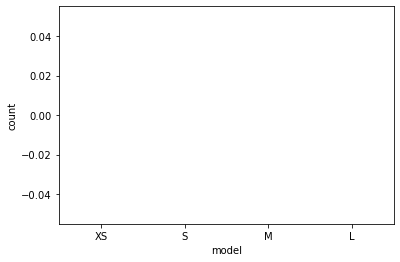

In [116]:
# "XS" is overpopulated
sns.countplot(data=car_df, x="model", order=C)

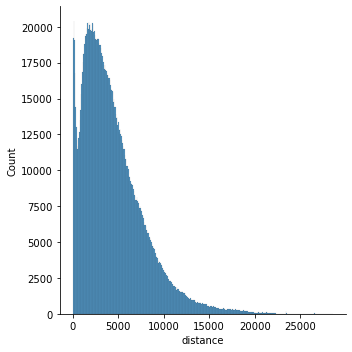

In [117]:
sns.displot(car_df, x="distance")

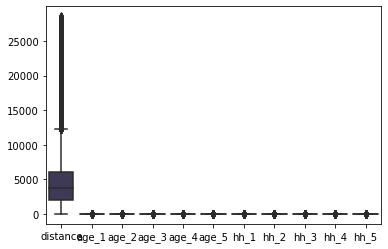

In [196]:
# palette = sns.light_palette("#786fa6")
ax = sns.boxplot(data=learning_df, palette=palette)


In [46]:
car_df["model_lc"] = car_df["model"].apply(lambda a: a.lower())


/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_84983/1998724020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df["model_lc"] = car_df["model"].apply(lambda a: a.lower())


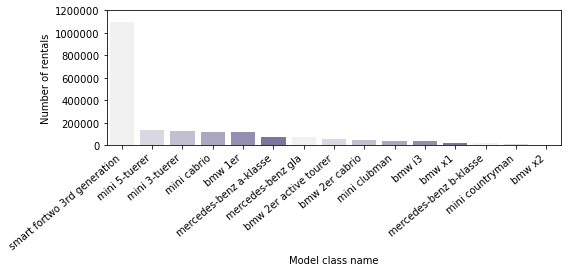

In [47]:

plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high

palette = sns.light_palette("#786fa6")ax = sns.countplot(data=car_df, x="model_lc", palette=palette, order=car_df["model_lc"].value_counts().index)
ax.set_ylim(0, 1200000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Model class name")
plt.ylabel("Number of rentals")
plt.show()

In [48]:
car_df["model_lc"].value_counts()[1:].sum()

883928

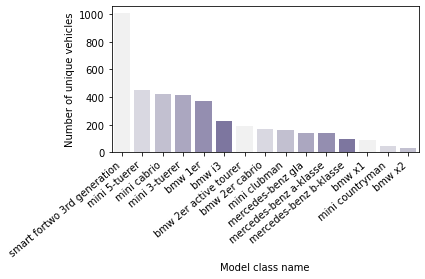

In [49]:
fleet_size = car_df[["model_lc", "id"]].groupby("model_lc").nunique()
fleet_size.sort_values(by="id", ascending=False, inplace=True)

ax = sns.barplot(x=fleet_size.index, y=fleet_size.values.reshape(1, -1)[0], palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.xlabel("Model class name")
plt.ylabel("Number of unique vehicles")
plt.show()
# fleet_size.index, fleet_size.values.reshape(1, -1)[0]


In [50]:
fleet_size

,id
model_lc,
smart fortwo 3rd generation,1007
mini 5-tuerer,452
mini cabrio,420
mini 3-tuerer,412
bmw 1er,371
bmw i3,225
bmw 2er active tourer,188
bmw 2er cabrio,170
mini clubman,164


In [51]:
fleet_ids = fleet_size["id"]
fleet_size.max(), fleet_size.min(), fleet_size.sum(), fleet_size

(id    1007
 dtype: int64,
 id    29
 dtype: int64,
 id    3946
 dtype: int64,
                                id
 model_lc                         
 smart fortwo 3rd generation  1007
 mini 5-tuerer                 452
 mini cabrio                   420
 mini 3-tuerer                 412
 bmw 1er                       371
 bmw i3                        225
 bmw 2er active tourer         188
 bmw 2er cabrio                170
 mini clubman                  164
 mercedes-benz gla             140
 mercedes-benz a-klasse        138
 mercedes-benz b-klasse         96
 bmw x1                         90
 mini countryman                44
 bmw x2                         29)

In [52]:
count = fdf.groupby("class").count().min(axis=1).min()

def truncate_class(c):
  a = fdf[fdf["class"] == c];
  shuffle(a)
  a = a[:count]
  return a

fdf = pd.concat([truncate_class(c) for c in C])
fdf.dropna(inplace=True)

<AxesSubplot:xlabel='class', ylabel='count'>

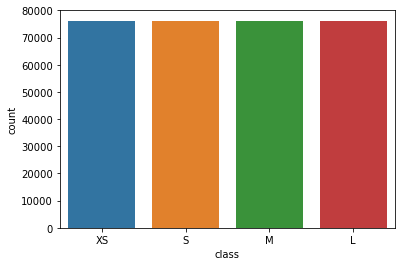

In [53]:
# now not anymore
sns.countplot(data=fdf, x="class", order=C)

In [54]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

X = fdf[[*age_columns, *income_columns]]
Y = fdf["class"]

# Oversample using SMOTE
# sm = SMOTE(random_state=42)
# x_smote, y_smote = sm.fit_resample(X, Y)

# enn = EditedNearestNeighbours()
# x_train_enn, y_train_enn = enn.fit_resample(X, Y)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [56]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
clf_classes = clf.classes_

In [57]:
clf_classes

array(['L', 'M', 'S', 'XS'], dtype='<U2')

In [58]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
 
# Test the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [59]:
print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test,y_pred))
# print("Precision Score : ",precision_score(y_test,y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))
# print("Recall Score : ",recall_score(y_test,y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))

              precision    recall  f1-score   support

           L       0.29      0.26      0.28     25056
           M       0.26      0.01      0.02     25324
           S       0.26      0.14      0.18     25063
          XS       0.26      0.66      0.37     25091

    accuracy                           0.27    100534
   macro avg       0.27      0.27      0.21    100534
weighted avg       0.27      0.27      0.21    100534



In [60]:
import seaborn as sns


In [61]:
districts = car_df[["Bezirk", *age_columns, *income_columns]].groupby("Bezirk")
districts = districts.mean()
districts

,age_1,age_2,age_3,age_4,age_5,income_1,income_2,income_3
Bezirk,,,,,,,,
Charlottenburg-Wilmersdorf,0.123079,0.140888,0.302905,0.229919,0.202133,0.111111,0.219711,0.669178
Friedrichshain-Kreuzberg,0.139398,0.228086,0.402182,0.142070,0.088667,0.103321,0.252768,0.643911
Lichtenberg,0.134149,0.227674,0.314316,0.154995,0.165672,0.105007,0.303894,0.591099
Marzahn-Hellersdorf,0.053946,0.073412,0.359581,0.281442,0.290725,0.098308,0.334408,0.567284
Mitte,0.135419,0.202108,0.359508,0.173679,0.123577,0.121999,0.257227,0.620774
Neukölln,0.151477,0.229315,0.347822,0.157850,0.110043,0.161462,0.330897,0.507641
Pankow,0.153491,0.176553,0.456156,0.114065,0.099470,0.054735,0.175934,0.769331
Reinickendorf,0.150690,0.153332,0.287866,0.187798,0.215375,0.114338,0.283122,0.602541
Spandau,0.122525,0.166797,0.284795,0.223052,0.188497,0.140535,0.283939,0.575526


In [62]:
# Figure out and normalize data per sector
def normalize_columns(columns):
  total = districts[columns].sum(axis=1)
  for c in columns:
    districts[c] = districts[c] / total

normalize_columns(age_columns)
normalize_columns(income_columns)

In [63]:
districts

,age_1,age_2,age_3,age_4,age_5,income_1,income_2,income_3
Bezirk,,,,,,,,
Charlottenburg-Wilmersdorf,0.123212,0.141040,0.303231,0.230167,0.202350,0.111111,0.219711,0.669178
Friedrichshain-Kreuzberg,0.139342,0.227994,0.402020,0.142012,0.088632,0.103321,0.252768,0.643911
Lichtenberg,0.134579,0.228404,0.315323,0.155492,0.166203,0.105007,0.303894,0.591099
Marzahn-Hellersdorf,0.050936,0.069315,0.339514,0.265736,0.274500,0.098308,0.334408,0.567284
Mitte,0.136196,0.203269,0.361572,0.174676,0.124287,0.121999,0.257227,0.620774
Neukölln,0.152008,0.230119,0.349041,0.158403,0.110429,0.161462,0.330897,0.507641
Pankow,0.153531,0.176600,0.456277,0.114096,0.099496,0.054735,0.175934,0.769331
Reinickendorf,0.151438,0.154093,0.289295,0.188730,0.216444,0.114338,0.283122,0.602541
Spandau,0.124307,0.169223,0.288936,0.226296,0.191238,0.140535,0.283939,0.575526


In [67]:
def predice_choices(d, alpha):
  p = clf.predict_proba([d])[0]
  i = p.argmax()
  print(p)
  p_max = p[i]

  choices = filter(lambda a: p[a[0]] >= p_max - alpha, enumerate(clf_classes))
  choices = map(lambda a: a[1], choices)

  return list(choices)


def predict_district(name: str, alpha: float):
  return predice_choices(districts.loc[name][[*age_columns, *income_columns]], alpha)
  

print([(on, predict_district(on, 0.04)) for on in districts.index])



[0.20260529 0.24364528 0.25744399 0.29630544]
[0.18040645 0.2515627  0.2599349  0.30809595]
[0.15097904 0.2593563  0.25486506 0.3347996 ]
[0.19987258 0.26725548 0.25459268 0.27827927]
[0.16307563 0.2486588  0.25347919 0.33478638]
[0.08106455 0.30581397 0.26845921 0.34466228]
[0.15971667 0.31424528 0.33612619 0.18991186]
[0.17281845 0.24772601 0.24772172 0.33173382]
[0.1511021  0.25644906 0.24898427 0.34346457]
[0.21040424 0.24307401 0.2570611  0.28946065]
[0.17968224 0.24476851 0.25460945 0.3209398 ]
[0.23311201 0.25514698 0.26524162 0.24649939]
[('Charlottenburg-Wilmersdorf', ['S', 'XS']), ('Friedrichshain-Kreuzberg', ['XS']), ('Lichtenberg', ['XS']), ('Marzahn-Hellersdorf', ['M', 'S', 'XS']), ('Mitte', ['XS']), ('Neukölln', ['M', 'XS']), ('Pankow', ['M', 'S']), ('Reinickendorf', ['XS']), ('Spandau', ['XS']), ('Steglitz-Zehlendorf', ['S', 'XS']), ('Tempelhof-Schöneberg', ['XS']), ('Treptow-Köpenick', ['L', 'M', 'S', 'XS'])]


/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: Us

In [102]:
dt = pd.to_datetime(car_df["datetime_start"][0:50000], errors="raise")  
dt

303541   2020-01-17 11:48:08+01:00
303542   2020-01-17 12:18:08+01:00
303543   2020-01-17 14:58:24+01:00
303544   2020-01-17 17:33:07+01:00
303545   2020-01-18 04:33:09+01:00
                    ...           
353536   2020-02-25 12:43:13+01:00
353537   2020-02-26 05:53:08+01:00
353538   2020-02-26 18:23:07+01:00
353539   2020-02-26 18:53:07+01:00
353540   2020-03-03 11:43:07+01:00
Name: datetime_start, Length: 50000, dtype: datetime64[ns, pytz.FixedOffset(60)]

Text(0, 0.5, 'Rides')

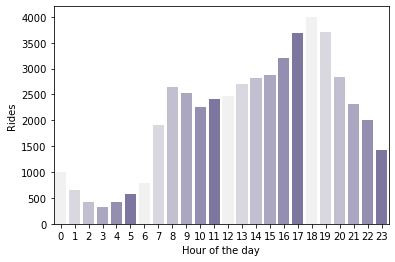

In [115]:
v = car_df[0:50000].groupby(dt.dt.hour).count()["id"]
sns.barplot(x=v.index, y=v.values, palette=palette)

plt.xlabel("Hour of the day")
plt.ylabel("Rides")

In [88]:
dt

303541    2020-01-17 11:48:08+01:00
303542    2020-01-17 12:18:08+01:00
303543    2020-01-17 14:58:24+01:00
303544    2020-01-17 17:33:07+01:00
303545    2020-01-18 04:33:09+01:00
                    ...            
403536    2019-12-13 13:38:08+01:00
403537    2019-12-13 16:03:10+01:00
403538    2019-12-13 17:33:09+01:00
403539    2019-12-13 21:18:07+01:00
403540    2019-12-14 00:48:42+01:00
Name: datetime_start, Length: 100000, dtype: object

In [65]:
predice_choices([0, 1, 0, 0, 0, 0, 0, 1], 0.1), clf_classes

[8.76835337e-01 7.14055228e-02 5.15942594e-02 1.64881029e-04]


/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


(['L'], array(['L', 'M', 'S', 'XS'], dtype='<U2'))

In [66]:
predice_choices([0, 0, 0, 1, 0, 0, 1, 0], 0.1), clf_classes

[5.04441407e-09 9.48992933e-01 5.10068035e-02 2.58051101e-07]


/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


(['M'], array(['L', 'M', 'S', 'XS'], dtype='<U2'))

In [ ]:
predice_choices([0, 0, 0.3, 0, 0, 0, 0, 1], 0.1), clf_classes

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X_train, y_train)

In [ ]:
times = car_df[["datetime_start", "datetime_end"]]
times.min(), times.max()

In [ ]:
car_df["provider"].unique()

In [ ]:
car_df